In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
target_dates = pd.date_range(start="2025-03-01", end="2025-05-16").strftime("%Y-%m-%d").tolist()

# 印出前幾天確認
print(target_dates[:5])
print(f"總共事件日數: {len(target_dates)}") 

['2025-03-01', '2025-03-02', '2025-03-03', '2025-03-04', '2025-03-05']
總共事件日數: 77


In [3]:
# === 1. 讀取資料 ===
df = pd.read_csv("daily_sentiment_features.csv")
df["date"] = pd.to_datetime(df["date"])

# === 2. 設定事件日與觀察區間 ===
#target_dates = ["2025-03-11", "2025-04-02", "2025-05-12"]
window = 4 # 前後天數

# === 3. 結果紀錄列表 ===
significant_events = []

# === 4. 遍歷每個事件日 ===
for d in target_dates:
    df["group"] = None  # 重置分組欄位
    center = pd.to_datetime(d)

    # 標記 group
    df.loc[(df["date"] >= center - pd.Timedelta(days=window)) & 
           (df["date"] < center), "group"] = f"{d}_before"
    df.loc[(df["date"] > center) & 
           (df["date"] <= center + pd.Timedelta(days=window)), "group"] = f"{d}_after"

    df_subset = df[df["group"].notna()]

    g1 = df_subset[df_subset["group"] == f"{d}_before"]["avg_sentiment_score"]
    g2 = df_subset[df_subset["group"] == f"{d}_after"]["avg_sentiment_score"]

    # 檢查樣本數是否足夠
    if len(g1) >= 2 and len(g2) >= 2:
        t_stat, p_val = ttest_ind(g1, g2)
        #print(f"🔍 {d} | t = {t_stat:.4f}, p = {p_val:.4f}")

        if p_val < 0.05:
            significant_events.append((d, t_stat, p_val))
    else:
        print(f"⚠️ {d} 樣本不足（before={len(g1)}, after={len(g2)}）")

# === 5. 列出顯著事件總表 ===
if significant_events:
    print("\n✅ 顯著事件列表（p < 0.05）:")
    for d, t, p in significant_events:
        print(f"- {d}: t = {t:.4f}, p = {p:.4f}")
else:
    print("\n❌ 無顯著事件（p < 0.05）")


⚠️ 2025-03-01 樣本不足（before=0, after=4）
⚠️ 2025-03-02 樣本不足（before=1, after=4）
⚠️ 2025-05-15 樣本不足（before=4, after=1）
⚠️ 2025-05-16 樣本不足（before=4, after=0）

✅ 顯著事件列表（p < 0.05）:
- 2025-03-19: t = -2.5500, p = 0.0435
- 2025-04-16: t = 2.8657, p = 0.0286
- 2025-05-07: t = -2.6965, p = 0.0357


<Figure size 1000x600 with 0 Axes>

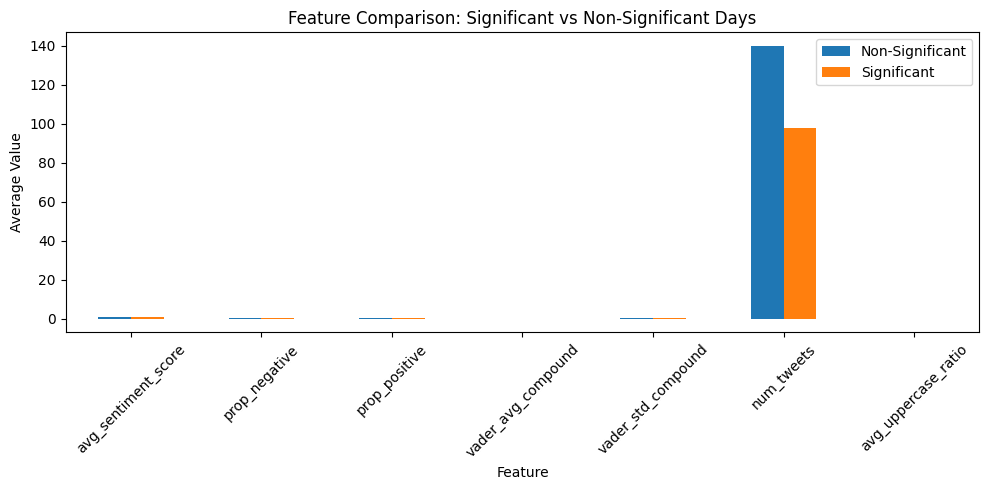

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 將顯著事件標記到主資料表
df["is_significant"] = df["date"].isin([pd.to_datetime(d[0]) for d in significant_events])

# 要分析的特徵欄位（你可以自行更換）
feature_cols = [
    'avg_sentiment_score',
    'prop_negative', 'prop_positive',
    'vader_avg_compound', 'vader_std_compound',
    'num_tweets', 'avg_uppercase_ratio'
]

# 計算每組平均
group_mean = df.groupby("is_significant")[feature_cols].mean().T
group_mean.columns = ["Non-Significant", "Significant"]

# === Plot: Feature Mean Comparison (English Labels) ===
plt.figure(figsize=(10, 6))
group_mean.plot(kind="bar", figsize=(10, 5), title="Feature Comparison: Significant vs Non-Significant Days")
plt.ylabel("Average Value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


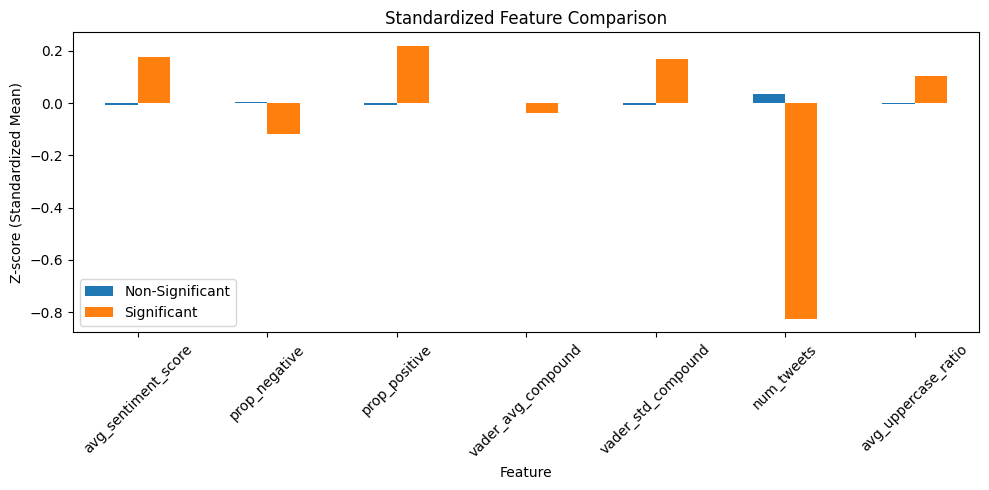

In [8]:
from sklearn.preprocessing import StandardScaler

# 只針對選定特徵進行標準化
scaler = StandardScaler()
scaled = scaler.fit_transform(df[feature_cols])

# 重新建立標準化後的 DataFrame
df_scaled = pd.DataFrame(scaled, columns=feature_cols)
df_scaled["is_significant"] = df["is_significant"]

# 計算群組平均（標準化後）
group_scaled = df_scaled.groupby("is_significant")[feature_cols].mean().T
group_scaled.columns = ["Non-Significant", "Significant"]

# 繪圖
group_scaled.plot(kind="bar", figsize=(10, 5), title="Standardized Feature Comparison")
plt.ylabel("Z-score (Standardized Mean)")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. On significant event days, the total number of tweets is substantially lower than average, which might indicate a suppression or fragmentation of discussion, or increased lurking behavior.
2. We observed a higher variability in compound sentiment scores, implying that public emotional responses became more polarized or inconsistent on significant days.
3. Interestingly, both the proportion of positive tweets and the use of uppercase characters slightly increased, which could suggest intensified emotional expressions (possibly sarcasm or emphatic tone).

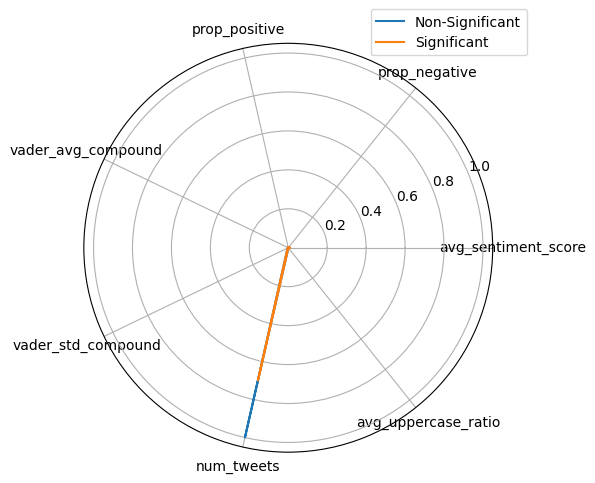

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 特徵欄位（依照你先前用的）
feature_cols = [
    'avg_sentiment_score', 'prop_negative', 'prop_positive',
    'vader_avg_compound', 'vader_std_compound',
    'num_tweets', 'avg_uppercase_ratio'
]

# 計算平均值
group_mean = df.groupby("is_significant")[feature_cols].mean()

# 把兩組資料變成 list 並標準化到 0~1 之間
data_min = group_mean.min().min()
data_max = group_mean.max().max()

normalized = (group_mean - data_min) / (data_max - data_min)

labels = feature_cols
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # 關閉 radar 繞一圈

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, label in enumerate(["Non-Significant", "Significant"]):
    values = normalized.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, label=label)
    ax.fill(angles, values, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
#ax.set_title("Radar Chart of Normalized Features")
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


In [12]:
from scipy.stats import ttest_ind

# 顯著 vs 非顯著分組
sig_group = df[df["is_significant"] == True]
non_group = df[df["is_significant"] == False]

# 建立結果列表
t_results = []

for col in feature_cols:
    g1 = non_group[col].dropna()
    g2 = sig_group[col].dropna()

    if len(g1) >= 2 and len(g2) >= 2:
        t_stat, p_val = ttest_ind(g1, g2, equal_var=False)
        t_results.append((col, t_stat, p_val))
    else:
        t_results.append((col, np.nan, np.nan))

# 結果變成表格
t_df = pd.DataFrame(t_results, columns=["Feature", "T-statistic", "P-value"])
t_df["Significant (p<0.05)"] = t_df["P-value"] < 0.05

print(t_df)


               Feature  T-statistic   P-value  Significant (p<0.05)
0  avg_sentiment_score    -0.455429  0.686870                 False
1        prop_negative     0.358423  0.747113                 False
2        prop_positive    -0.377769  0.739495                 False
3   vader_avg_compound     0.078947  0.943568                 False
4   vader_std_compound    -0.959825  0.374646                 False
5           num_tweets     1.572502  0.245560                 False
6  avg_uppercase_ratio    -0.120864  0.914517                 False


While several days were identified as statistically significant based on changes in daily average sentiment, further t-tests conducted on other social media behavior features (e.g., tweet volume, sentiment proportions, lexical style) did not yield statistically significant differences between significant and non-significant days.
This suggests that although average sentiment shifted, other behavioral features may have remained stable or the dataset size may have limited statistical power.

### Try set window = 2 (More short term)

In [22]:
# === 1. 讀取資料 ===
df = pd.read_csv("daily_sentiment_features.csv")
df["date"] = pd.to_datetime(df["date"])

# === 2. 設定事件日與觀察區間 ===
#target_dates = ["2025-03-11", "2025-04-02", "2025-05-12"]
window = 2 # 前後天數

# === 3. 結果紀錄列表 ===
significant_events = []

# === 4. 遍歷每個事件日 ===
for d in target_dates:
    df["group"] = None  # 重置分組欄位
    center = pd.to_datetime(d)

    # 標記 group
    df.loc[(df["date"] >= center - pd.Timedelta(days=window)) & 
           (df["date"] < center), "group"] = f"{d}_before"
    df.loc[(df["date"] > center) & 
           (df["date"] <= center + pd.Timedelta(days=window)), "group"] = f"{d}_after"

    df_subset = df[df["group"].notna()]

    g1 = df_subset[df_subset["group"] == f"{d}_before"]["avg_sentiment_score"]
    g2 = df_subset[df_subset["group"] == f"{d}_after"]["avg_sentiment_score"]

    # 檢查樣本數是否足夠
    if len(g1) >= 2 and len(g2) >= 2:
        t_stat, p_val = ttest_ind(g1, g2)
        #print(f"🔍 {d} | t = {t_stat:.4f}, p = {p_val:.4f}")

        if p_val < 0.05:
            significant_events.append((d, t_stat, p_val))
    else:
        print(f"⚠️ {d} 樣本不足（before={len(g1)}, after={len(g2)}）")

# === 5. 列出顯著事件總表 ===
if significant_events:
    print("\n✅ 顯著事件列表（p < 0.05）:")
    for d, t, p in significant_events:
        print(f"- {d}: t = {t:.4f}, p = {p:.4f}")
else:
    print("\n❌ 無顯著事件（p < 0.05）")


⚠️ 2025-03-01 樣本不足（before=0, after=2）
⚠️ 2025-03-02 樣本不足（before=1, after=2）
⚠️ 2025-05-15 樣本不足（before=2, after=1）
⚠️ 2025-05-16 樣本不足（before=2, after=0）

✅ 顯著事件列表（p < 0.05）:
- 2025-03-06: t = 5.3803, p = 0.0329
- 2025-03-15: t = -7.8643, p = 0.0158


<Figure size 1000x600 with 0 Axes>

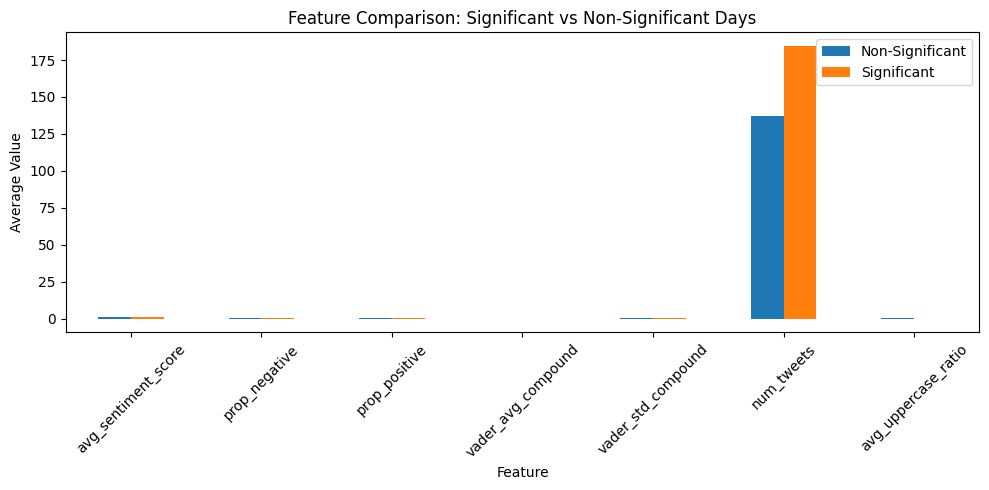

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 將顯著事件標記到主資料表
df["is_significant"] = df["date"].isin([pd.to_datetime(d[0]) for d in significant_events])

# 要分析的特徵欄位（你可以自行更換）
feature_cols = [
    'avg_sentiment_score',
    'prop_negative', 'prop_positive',
    'vader_avg_compound', 'vader_std_compound',
    'num_tweets', 'avg_uppercase_ratio'
]

# 計算每組平均
group_mean = df.groupby("is_significant")[feature_cols].mean().T
group_mean.columns = ["Non-Significant", "Significant"]

# === Plot: Feature Mean Comparison (English Labels) ===
plt.figure(figsize=(10, 6))
group_mean.plot(kind="bar", figsize=(10, 5), title="Feature Comparison: Significant vs Non-Significant Days")
plt.ylabel("Average Value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


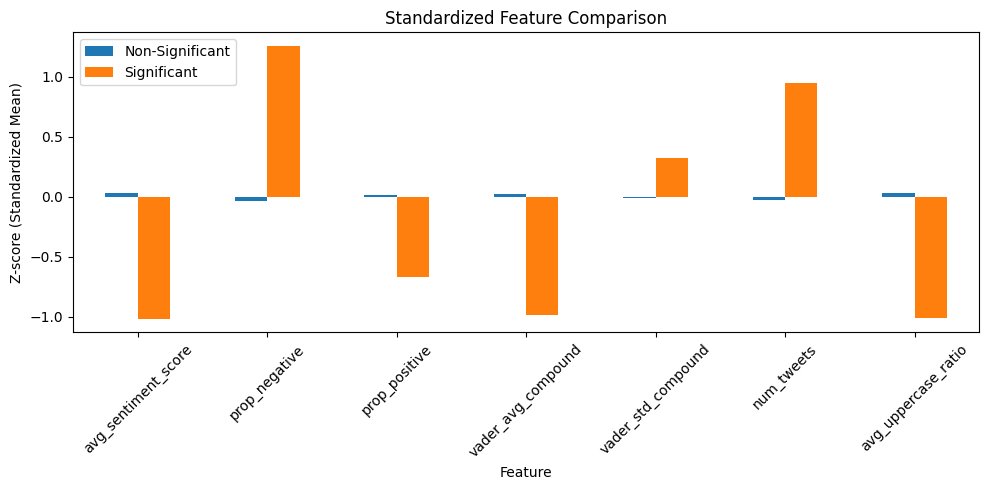

In [24]:
from sklearn.preprocessing import StandardScaler

# 只針對選定特徵進行標準化
scaler = StandardScaler()
scaled = scaler.fit_transform(df[feature_cols])

# 重新建立標準化後的 DataFrame
df_scaled = pd.DataFrame(scaled, columns=feature_cols)
df_scaled["is_significant"] = df["is_significant"]

# 計算群組平均（標準化後）
group_scaled = df_scaled.groupby("is_significant")[feature_cols].mean().T
group_scaled.columns = ["Non-Significant", "Significant"]

# 繪圖
group_scaled.plot(kind="bar", figsize=(10, 5), title="Standardized Feature Comparison")
plt.ylabel("Z-score (Standardized Mean)")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
from scipy.stats import ttest_ind

# 顯著 vs 非顯著分組
sig_group = df[df["is_significant"] == True]
non_group = df[df["is_significant"] == False]

# 建立結果列表
t_results = []

for col in feature_cols:
    g1 = non_group[col].dropna()
    g2 = sig_group[col].dropna()

    if len(g1) >= 2 and len(g2) >= 2:
        t_stat, p_val = ttest_ind(g1, g2, equal_var=False)
        t_results.append((col, t_stat, p_val))
    else:
        t_results.append((col, np.nan, np.nan))

# 結果變成表格
t_df = pd.DataFrame(t_results, columns=["Feature", "T-statistic", "P-value"])
t_df["Significant (p<0.05)"] = t_df["P-value"] < 0.05

print(t_df)


               Feature  T-statistic       P-value  Significant (p<0.05)
0  avg_sentiment_score     8.404785  3.232782e-10                  True
1        prop_negative    -9.998302  2.373205e-09                  True
2        prop_positive     3.737703  3.667578e-02                  True
3   vader_avg_compound     4.736489  4.079310e-02                  True
4   vader_std_compound    -0.664147  6.169218e-01                 False
5           num_tweets    -3.703925  9.539545e-02                 False
6  avg_uppercase_ratio     2.858936  1.734128e-01                 False
